# Recursive Forecasting
25 March 2024  
Conda environment: `time-series`

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

In [10]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200
# Output a pandas df intead of numpy
set_config(transform_output="pandas")

## 1) Input data

In [6]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

data

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


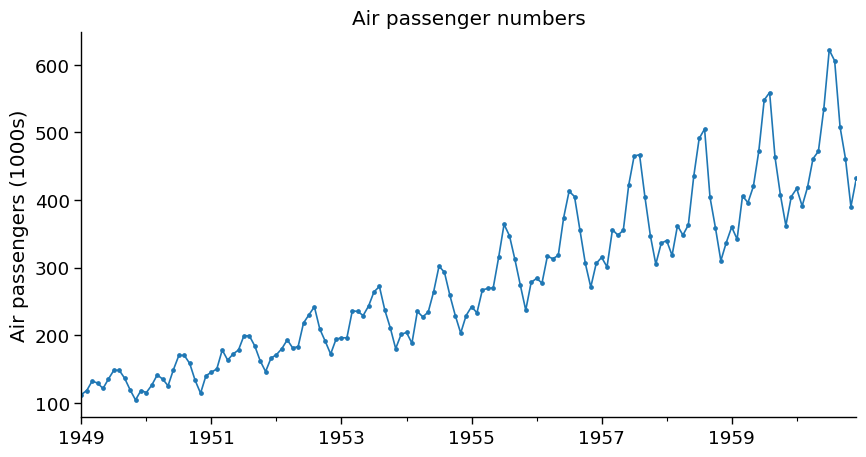

In [9]:
data.plot(y="y", marker=".", figsize=[10, 5], legend=None)

plt.ylabel("Air passengers (1000s)")
plt.xlabel("")
plt.title("Air passenger numbers")

plt.show()

## 2) Features

In [11]:
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
